CNN models used for image super-resolution:
RUNet  

*   RUNet
*   RDN - Residual Dense Network  
https://keras.io/examples/vision/edsr/  
https://arxiv.org/abs/1707.02921
*   SAN - Second-Order Attention Network
*   ABPN - Attention based Back Projection Networks





1. Wybrać końcowy dataset,  
Dataset "cheetahhyenajaguartiger" z Kaggle
- 4 klasy  
- 3600 obrazów treningowych  
- 400 obrazów testowych  

2. Uruchomić model klasyfikujący,
przetestować jak gotowy model sprawdza się na naszych obrazach - porównać obrazy o roździelczości  np. 200x200 i 50x50   

- Resnet na ImageNet dobrze klasyfikuje obrazy 224x224,  
ale nie radzi sobie z 56x56
- po transfer learningu jest znacznie lepiej

3. Dodać metody nie związane z głębokim uczeniem (interpolacja),
4. Własna implementacja wybranej architektury.

squeeze and exite?
skip conncection?


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow_datasets as tfds
from tensorflow.python.keras import layers

Dane ściagane z kaggle, po odpaleniu poniższej komórki musisz wrzucić swojego kaggle.json

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d naredlaajayreddy/cheetahhyenajaguartiger
! unzip cheetahhyenajaguartiger.zip 

100% 312M/313M [00:10<00:00, 36.4MB/s]
100% 313M/313M [00:10<00:00, 32.6MB/s]
Archive:  cheetahhyenajaguartiger.zip
  inflating: data/test/Cheetah/cheetah_000_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_001_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_002_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_003_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_004_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_005_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_006_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_007_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_008_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_009_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_010_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_011_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_012_val_resized.jpg  
  inflating: data/test/Cheetah/cheetah_013_val_resized.jpg  
  inflating: data/test/Cheetah

In [ ]:
train_path = "/content/data/train/"

filenames = os.listdir(train_path)

In [ ]:
IMG_SIZE = 224
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
  # image = tf.cast(image, tf.float32)
  # image = (image / 255.0)
  image = tf.image.random_crop(image, size=[180, 180, 3])
  image = tf.image.random_brightness(image, max_delta=1.0)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.image.random_flip_left_right(image)
  return image, label

# train_ds = tf.keras.utils.image_dataset_from_directory(
#               train_path, validation_split=0.2, subset="training", 
#               image_size=(224, 224), seed=1, shuffle=True)


# counter = tf.data.experimental.Counter()
# train_ds = tf.data.Dataset.zip((train_ds, (counter, counter)))

# train_ds = (
#     train_ds
#     .shuffle(1000)
#     .map(augment, num_parallel_calls=AUTOTUNE)
#     .batch(batch_size)
#     # .prefetch(AUTOTUNE)
# )

Found 3600 files belonging to 4 classes.
Using 2880 files for training.
Found 3600 files belonging to 4 classes.
Using 2880 files for training.
Images size: (224, 224, 3)


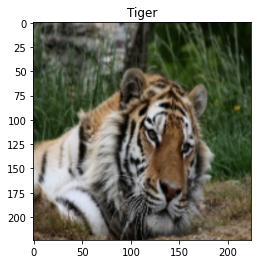

Images size: (224, 224, 3)


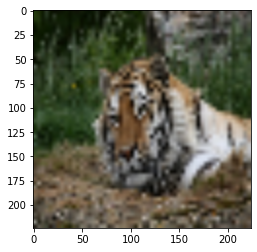

In [ ]:
# resnet requires 224x224
images_hr = tf.keras.utils.image_dataset_from_directory(
              train_path, validation_split=0.2, subset="training", 
              image_size=(224, 224), seed=1, shuffle=True)
images_lr = tf.keras.utils.image_dataset_from_directory(
              train_path, validation_split=0.2, subset="training", 
              image_size=(56, 56), seed=1, shuffle=True)

class_names = images_hr.class_names

plt.figure()

for images, labels in images_hr.take(1):
  img, label = augment(images[1], labels[1])
  print(f'Images size: {img.shape}')
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.show()
  # print(f'Images size: {images[0].shape}')
  # plt.imshow(images[1].numpy().astype("uint8"))
  # plt.title(class_names[labels[1]])
  # plt.show()
    
for images, labels in images_lr.take(1):
  images = tf.image.resize(np.array(images), [224, 224])
  print(f'Images size: {images[0].shape}')
  plt.imshow(images[1].numpy().astype("uint8"))  
  plt.show()

In [ ]:
pip install keras-resnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=ee39cf2d52e9519e758b1dec89e7f44fd194b21e0372bcfa57a48cb591a333e2
  Stored in directory: /root/.cache/pip/wheels/be/90/98/9d455f04a7ca277366b36c660c89d171ff5abb7bdd8a8b8e75
Successfully built keras-resnet


In [ ]:
from keras_resnet.models import ResNet152
resnet_model = keras.applications.resnet.ResNet152(weights='imagenet')

# resnet_model = keras.applications.resnet.ResNet50(weights='imagenet')

242900224/242900224 [==============================] - 9s 0us/step


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomContrast(0.1),
  preprocessing.RandomZoom(-0.3, -0.2)
])

['Cheetah', 'Hyena', 'Jaguar', 'Tiger']
35363/35363 [==============================] - 0s 0us/step
Image HR: Jaguar
  n02128925 - jaguar 52.92 %
  n02128385 - leopard 30.78 %
  n02130308 - cheetah 8.27 %
Image LR:
  n02128385 - leopard 34.7 %
  n02130308 - cheetah 28.95 %
  n02128925 - jaguar 23.21 %


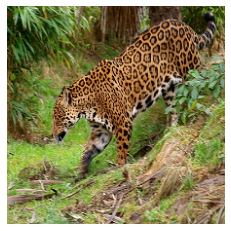

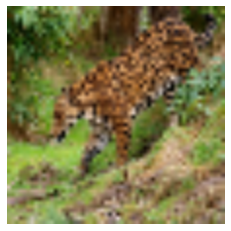


1/1 [==============================] - 0s 36ms/step
Image HR: Hyena
  n02114855 - coyote 39.99 %
  n02117135 - hyena 19.83 %
  n02123159 - tiger_cat 12.21 %
Image LR:
  n02356798 - fox_squirrel 79.76 %
  n01883070 - wombat 8.39 %
  n02128757 - snow_leopard 1.91 %


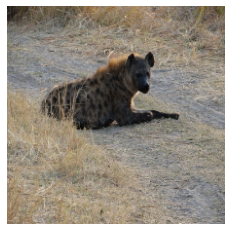

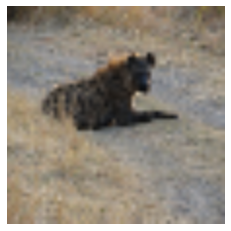


1/1 [==============================] - 0s 73ms/step
Image HR: Cheetah
  n02130308 - cheetah 86.36 %
  n02128385 - leopard 10.31 %
  n02128757 - snow_leopard 2.66 %
Image LR:
  n02088632 - bluetick 58.92 %
  n02100236 - German_short-haired_pointer 17.95 %
  n02128385 - leopard 2.96 %


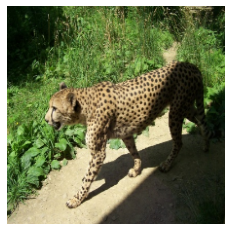

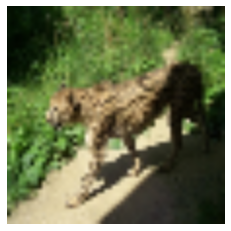


1/1 [==============================] - 0s 49ms/step
Image HR: Tiger
  n02129604 - tiger 99.05 %
  n02123159 - tiger_cat 0.7 %
  n02128757 - snow_leopard 0.18 %
Image LR:
  n02129604 - tiger 90.48 %
  n02101556 - clumber 6.68 %
  n02123159 - tiger_cat 0.56 %


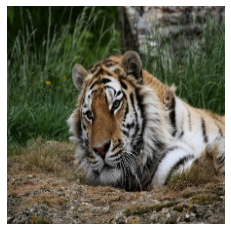

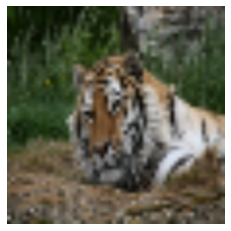


1/1 [==============================] - 0s 59ms/step
Image HR: Cheetah
  n02130308 - cheetah 98.38 %
  n02128385 - leopard 1.07 %
  n02117135 - hyena 0.2 %
Image LR:
  n02423022 - gazelle 28.14 %
  n02114855 - coyote 15.47 %
  n02115913 - dhole 13.14 %


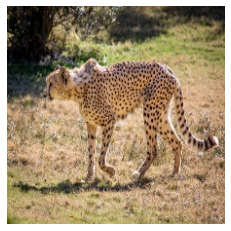

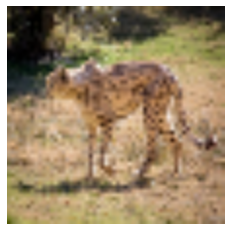

In [ ]:
print(class_names)

n = 5

for images, labels in images_hr.take(1):
  for i in range(n):
    
    y_hr = resnet_model.predict(images[i][np.newaxis,...])
    resized_images = tf.image.resize(images[i][np.newaxis,...], [56, 56])
    resized_images = tf.image.resize(resized_images, [224, 224])
    y_lr = resnet_model.predict(resized_images)

    # top_pred_hr = keras.applications.resnet50.decode_predictions(y_hr, top=3)
    # top_pred_lr = keras.applications.resnet50.decode_predictions(y_lr, top=3)

    top_pred_hr = tf.keras.applications.resnet_v2.decode_predictions(y_hr, top=3)
    top_pred_lr = tf.keras.applications.resnet_v2.decode_predictions(y_lr, top=3)

    print("Image HR: {}".format(class_names[labels[i]]))
    for name in top_pred_hr[0]:
      print(f"  {name[0]} - {name[1]} {round(name[2] * 100, 2)} %")

    print("Image LR:")
    for name in top_pred_lr[0]:
      print(f"  {name[0]} - {name[1]} {round(name[2] * 100, 2)} %")

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()
    plt.imshow(resized_images[0,:,:,:].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()
    print()


In [ ]:
path_test = "/content/data/test/"

# validation and training data cannot intersect
train_set = images_lr
valid_set = keras.utils.image_dataset_from_directory(
                                        train_path, validation_split=0.2, 
                                        subset="validation",
                                        seed=1, image_size=(56, 56))

test_set_lr = keras.utils.image_dataset_from_directory(
                                        path_test, 
                                        image_size=(56, 56), 
                                        seed=1)

Found 3600 files belonging to 4 classes.
Using 720 files for validation.
Found 400 files belonging to 4 classes.


In [ ]:
#transfer learning

base_model = keras.applications.resnet.ResNet152(
    weights='imagenet', include_top=False, input_shape=(None,None,3)
)

i = keras.layers.Input([None, None, 3], dtype = tf.float32)
x = tf.cast(i, tf.float32)
x = keras.applications.resnet.preprocess_input(x)
x = keras.layers.UpSampling2D((4,4), interpolation='bilinear')(x)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs=[i], outputs=[x])

for layer in base_model.layers:
    layer.trainable = False


234698864/234698864 [==============================] - 8s 0us/step


In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

loss_prior, accuracy_prior = model.evaluate(test_set_lr)

early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_set,
                    validation_data=valid_set,
                    callbacks=early_stop,
                    epochs=10)

13/13 [==============================] - 9s 306ms/step - loss: 1.9243 - accuracy: 0.2725
Epoch 1/10
90/90 [==============================] - 39s 349ms/step - loss: 0.9975 - accuracy: 0.6056 - val_loss: 0.4988 - val_accuracy: 0.8639
Epoch 2/10
90/90 [==============================] - 31s 341ms/step - loss: 0.4029 - accuracy: 0.8979 - val_loss: 0.3212 - val_accuracy: 0.9181
Epoch 3/10
90/90 [==============================] - 31s 340ms/step - loss: 0.2900 - accuracy: 0.9271 - val_loss: 0.2615 - val_accuracy: 0.9306
Epoch 4/10
90/90 [==============================] - 30s 332ms/step - loss: 0.2411 - accuracy: 0.9368 - val_loss: 0.2300 - val_accuracy: 0.9389
Epoch 5/10
90/90 [==============================] - 31s 340ms/step - loss: 0.2122 - accuracy: 0.9455 - val_loss: 0.2109 - val_accuracy: 0.9444
Epoch 6/10
90/90 [==============================] - 30s 335ms/step - loss: 0.1925 - accuracy: 0.9493 - val_loss: 0.1979 - val_accuracy: 0.9458
Epoch 7/10
90/90 [==============================] - 3

In [ ]:
loss_post, accuracy_post = model.evaluate(test_set_lr)

print(f'Before training\n Loss: {loss_prior}, Accuracy: {accuracy_prior}')
print(f'After training\n Loss: {loss_post}, Accuracy: {accuracy_post}')

13/13 [==============================] - 3s 240ms/step - loss: 0.1815 - accuracy: 0.9450
Before training
 Loss: 1.9242620468139648, Accuracy: 0.27250000834465027
After training
 Loss: 0.18149906396865845, Accuracy: 0.9449999928474426


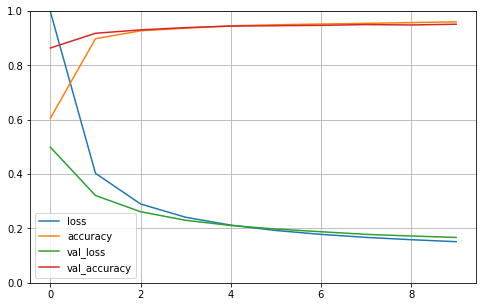

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

1/1 [==============================] - 5s 5s/step
Label: Hyena
LR  Hyena


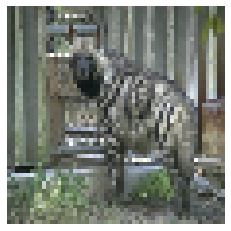

1/1 [==============================] - 0s 98ms/step
Label: Hyena
LR  Hyena


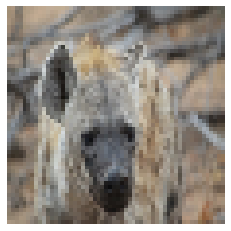

1/1 [==============================] - 0s 132ms/step
Label: Hyena
LR  Hyena


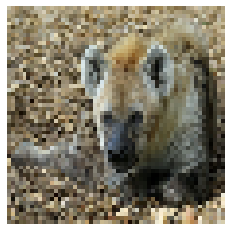

1/1 [==============================] - 0s 116ms/step
Label: Cheetah
LR  Cheetah


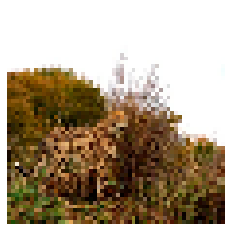

1/1 [==============================] - 0s 106ms/step
Label: Tiger
LR  Tiger


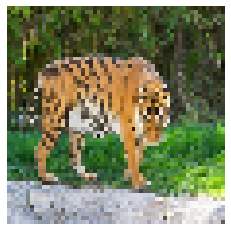

In [ ]:
n = 5

for images, labels in test_set_lr.take(1):
  for i in range(n):

    y_lr = model.predict(images[i][np.newaxis,...])

    print("Label: {}".format(test_set_lr.class_names[labels[i]]))
    print(f"LR  {test_set_lr.class_names[y_lr.argmax()]}")

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

## **RUNet**

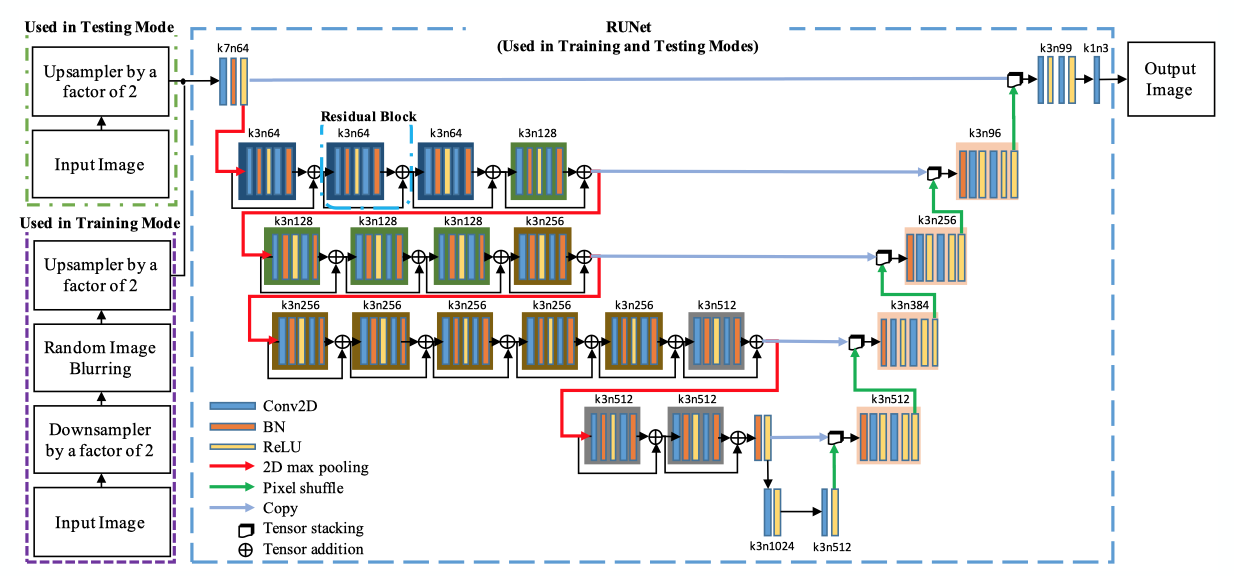

In [ ]:
def pixel_shuffle(scale):
    if scale > 1:
        return lambda x: tf.nn.depth_to_space(x, scale)
    else:
        return lambda x:x

In [ ]:
def residual_block_down(input, filters, last_block=False):
  block = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(input)
  block = keras.layers.BatchNormalization()(block)
  block = keras.layers.Activation("relu")(block)
  block = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(block)
  block = keras.layers.BatchNormalization()(block)
  if last_block:
    input = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding="same")(input)
  block = keras.layers.Add()([block, input])
  return block

def add_more_blocks(input, filters, num_of_blocks):
  block = residual_block_down(input, filters)
  if num_of_blocks == 1:
    block = residual_block_down(input, filters*2, last_block=True)
    return block
  else:
    return add_more_blocks(block, filters, num_of_blocks-1)

def residual_block_up(input_1, input_2, filters, upscale=2):
  input_1 = pixel_shuffle(scale=upscale)(input_1)
  block = keras.layers.Concatenate()([input_1, input_2])
  block = keras.layers.BatchNormalization()(block)
  block = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(block)
  block = keras.layers.Activation("relu")(block)
  block = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(block)
  block = keras.layers.Activation("relu")(block)
  block = keras.layers.Activation("relu")(block)
  return block

def RUnet(input_size):
  input = keras.layers.Input((input_size, input_size, 3))
  # input = keras.layers.UpSampling2D((4,4))(input)

  level_one = keras.layers.Conv2D(64,(7,7), padding="same")(input)
  level_one = keras.layers.BatchNormalization()(level_one)
  level_one = keras.layers.Activation("relu")(level_one)

  level_two = keras.layers.MaxPool2D(pool_size=(2,2))(level_one)
  level_two = add_more_blocks(level_two, 64, 4)

  level_three = keras.layers.MaxPool2D(pool_size=(2,2))(level_two)
  level_three = add_more_blocks(level_three, 128, 4)

  level_four = keras.layers.MaxPool2D(pool_size=(2,2))(level_three)
  level_four = add_more_blocks(level_four, 256, 6)

  level_five = keras.layers.MaxPool2D(pool_size=(2,2))(level_four)
  level_five = residual_block_down(level_five, 512)
  level_five = residual_block_down(level_five, 512)
  level_five = keras.layers.BatchNormalization()(level_five)
  level_five = keras.layers.Activation("relu")(level_five)

  level_six = keras.layers.Conv2D(1024, kernel_size=(3, 3), 
                                  padding="same")(level_five)
  level_six = keras.layers.Activation("relu")(level_six)
  level_six = keras.layers.Conv2D(512, kernel_size=(3, 3), 
                                  padding="same")(level_six)
  level_six = keras.layers.Activation("relu")(level_six)

  level_five = residual_block_up(level_six, level_five, 512, upscale=1)

  level_four = residual_block_up(level_five, level_four, 384)

  level_three = residual_block_up(level_four, level_three, 256)

  level_two = residual_block_up(level_three, level_two, 96)

  level_one_p = pixel_shuffle(scale=2)(level_two)
  level_one = keras.layers.Concatenate()([level_one_p, level_one])
  level_one = keras.layers.Conv2D(99, kernel_size=(3, 3), padding="same")(level_one)
  level_one = keras.layers.Activation("relu")(level_one)
  level_one = keras.layers.Conv2D(99, kernel_size=(3, 3), padding="same")(level_one)
  level_one = keras.layers.Activation('relu')(level_one)
  outputs = keras.layers.Conv2D(3, kernel_size=(1, 1), padding="same")(level_one)

  model = keras.models.Model(input, outputs)

  return model

RUnet = RUnet(input_size=224)
print(RUnet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
valid_set_hr = keras.utils.image_dataset_from_directory(
                                        train_path, validation_split=0.2, 
                                        subset="validation",
                                        label_mode=None,
                                        seed=1, image_size=(224, 224))

valid_set_lr = keras.utils.image_dataset_from_directory(
                                        train_path, validation_split=0.2, 
                                        subset="validation",
                                        label_mode=None,
                                        seed=1, image_size=(56, 56))
train_hr = keras.utils.image_dataset_from_directory(
                                        train_path, validation_split=0.2, 
                                        subset="training",
                                        label_mode=None,
                                        seed=1, image_size=(224, 224))

train_lr = keras.utils.image_dataset_from_directory(
                                        train_path, validation_split=0.2, 
                                        subset="training",
                                        label_mode=None,
                                        seed=1, image_size=(56, 56))

Found 3600 files belonging to 1 classes.
Using 720 files for validation.
Found 3600 files belonging to 1 classes.
Using 720 files for validation.
Found 3600 files belonging to 1 classes.
Using 2880 files for training.
Found 3600 files belonging to 1 classes.
Using 2880 files for training.


In [ ]:
batch_size = 16

def train_generator(train_list, y_list):
    while True:
        for start in range(0, len(train_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_list))
                    ids_train_batch = train_list[start:end]
                    y_train_batch = y_list[start:end]
                    for i,ids in enumerate(ids_train_batch):
                        img_y = y_train_batch[i]
                        # if ids == ids_train_batch[i]:
                        #   print('pictures are the same')
                        img_x = ids
                        x_batch.append(np.array(img_x,np.float32))
                        y_batch.append(np.array(img_y,np.float32))
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch
                    

def valid_generator(train_list, y_list):
    while True:
        for start in range(0, len(train_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_list))
                    ids_train_batch = train_list[start:end]
                    y_train_batch = y_list[start:end]
                    for i,ids in enumerate(ids_train_batch):
                        img_y = y_train_batch[i]
                        # if ids == ids_train_batch[i]:
                        #   print('pictures are the same')
                        img_x = ids
                        x_batch.append(np.array(img_x,np.float32))
                        y_batch.append(np.array(img_y,np.float32))
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch

In [ ]:
y_train = []
x_train = []
y_valid = []
x_valid = []
for images in train_hr.take(89):
  for i in range(len(images)):
    y_train.append(images[i])

for images in train_lr.take(89):
  for i in range(len(images)):
    x_train.append(images[i])

for images in valid_set_hr.take(89):
  for i in range(len(images)):
    y_valid.append(images[i])

for images in valid_set_lr.take(89):
  for i in range(len(images)):
    x_valid.append(images[i])

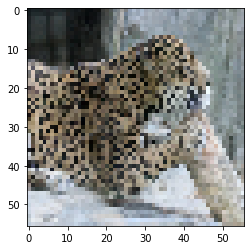

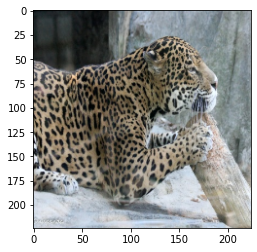

In [ ]:
x_train = np.array(x_train)/255
y_train = np.array(y_train)/255
x_valid = np.array(x_valid)/255
y_valid = np.array(y_valid)/255

plt.imshow(np.array(x_train[0]))
plt.show()
plt.imshow(np.array(y_train[0]))
plt.show()

In [ ]:
def pre_upsamping(data,training_mode=True):
    inputs = keras.layers.Input((None, None, 3))
    if training_mode:
        # training mode:gaussian noise and upsampling
        x = keras.layers.GaussianNoise(5)(inputs)
        x = keras.layers.UpSampling2D((4,4))(x)
    else:
        # testing mode: just an upsampling
        x = keras.layers.UpSampling2D((4,4))(inputs)

    model = keras.models.Model(inputs, x)

    for l in model.layers: l.trainable=False
    data = model(data)
    return data

x_train = pre_upsamping(x_train,training_mode=True)
x_valid = pre_upsamping(x_valid,training_mode=False)

(2848, 224, 224, 3) (720, 224, 224, 3)


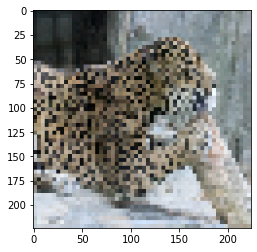

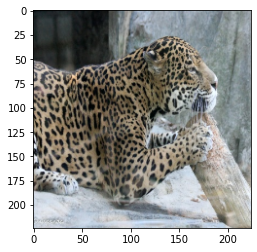

In [ ]:
print(x_train.shape, x_valid.shape)
plt.imshow(np.array(x_train[0]))
plt.show()
plt.imshow(np.array(y_train[0]))
plt.show()

In [ ]:
# Perceptual loss function 

# load pre-trained (imagenet) vgg network, excluding fully-connected layer on the top
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output) #sgd=0.1=9p, sgd=0.01=6p, adam=0.01=16p block3_conv3
#sgd=0.1=9p, sgd=0.01=13p, adam=0.01=16p block1_conv2
# vgg = base_model
# vgg_layer = keras.Model(inputs=vgg.input, outputs=vgg.get_layer('conv2_block2_3_conv').output)

for l in vgg_layer.layers: l.trainable=False 

def perceptual_loss(y_true,y_pred):
    '''This function computes the perceptual loss using an already trained VGG layer'''
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=keras.losses.mean_squared_error(y_t,y_p)
    return loss

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
# Peak Signal to Noise Ratio
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

# Structural Similarity Index Measure
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

In [ ]:
import cv2
optimizer = keras.optimizers.Adam(learning_rate=0.01)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
RUnet.compile(loss=perceptual_loss, optimizer=optimizer,
              metrics=[psnr,ssim, keras.losses.mean_squared_error])

early_stop = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

history = RUnet.fit(train_generator(x_train, y_train),
                    # x=x_train[:100], y=y_train[:100],
                    steps_per_epoch=np.ceil(float(len(x_train[:3200])) / float(32)),
                    validation_data=valid_generator(x_valid, y_valid),
                    validation_steps=np.ceil(float(len(x_valid[:172])) / float(32)),
                    # steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size*4)),
                    # validation_steps=np.ceil(float(len(x_valid)) / float(batch_size*4)),
                    # shuffle=True,
                    callbacks=early_stop,
                    epochs=20)

Epoch 1/20
89/89 [==============================] - 115s 1s/step - loss: 53.5429 - psnr: 8.2038 - ssim: 0.0983 - mean_squared_error: 0.8850 - val_loss: 14.4976 - val_psnr: 15.8809 - val_ssim: 0.4286 - val_mean_squared_error: 0.0266
Epoch 2/20
89/89 [==============================] - 91s 1s/step - loss: 12.8706 - psnr: 12.7219 - ssim: 0.3189 - mean_squared_error: 0.0565 - val_loss: 12.6486 - val_psnr: 16.8049 - val_ssim: 0.4744 - val_mean_squared_error: 0.0214
Epoch 3/20
89/89 [==============================] - 95s 1s/step - loss: 12.2077 - psnr: 14.9539 - ssim: 0.4040 - mean_squared_error: 0.0340 - val_loss: 11.9786 - val_psnr: 17.2512 - val_ssim: 0.5002 - val_mean_squared_error: 0.0195
Epoch 4/20
89/89 [==============================] - 95s 1s/step - loss: 11.8458 - psnr: 16.9167 - ssim: 0.4568 - mean_squared_error: 0.0220 - val_loss: 12.3705 - val_psnr: 18.1910 - val_ssim: 0.5165 - val_mean_squared_error: 0.0161
Epoch 5/20
89/89 [==============================] - 95s 1s/step - loss: 

1/1 [==============================] - 0s 21ms/step
lr
tf.Tensor(18.376144, shape=(), dtype=float32) tf.Tensor(0.6288772, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


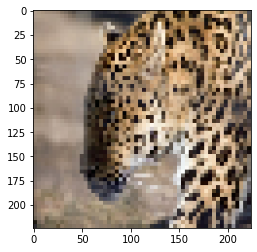

pred
tf.Tensor(18.52616, shape=(), dtype=float32) tf.Tensor(0.66262496, shape=(), dtype=float32)
1.0 0.0
1.0 0.0
<class 'numpy.ndarray'>


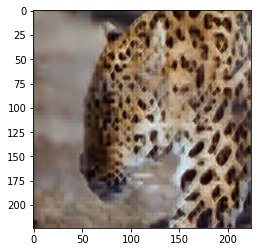

hr


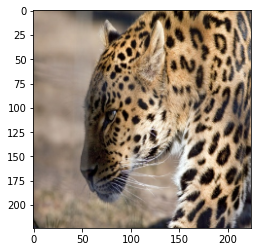

In [ ]:
import cv2  

k=1002
pred = RUnet.predict(x_train[k][np.newaxis,...])
print('lr')
print(psnr(y_train[k],x_train[k]), ssim(y_train[k],x_train[k]))
plt.imshow(x_train[k])
print(type(x_train[k]))
plt.show()

print('pred')
print(psnr(y_train[k],pred[0,:,:,:]), ssim(y_train[k],pred[0,:,:,:]))
img = pred[0,:,:,:]
img = img/np.amax(img)
img[img<0] = 0
print(np.amax(img), np.amin(img))
maxValue = np.amax(img)
minValue = np.amin(img)
print(maxValue, minValue)
plt.imshow(img)
# plt.imshow((out * 255).astype(np.uint8))
print(type(pred[0,:,:,:]))
plt.show()

print('hr')
# print(psnr(y_train[k], y_train[k]))
plt.imshow(y_train[k])
# print(type(y_train[k]))
plt.show()

Found 400 files belonging to 1 classes.
Using 320 files for training.
Found 400 files belonging to 1 classes.
Using 320 files for training.
1/1 [==============================] - 0s 21ms/step
lr
tf.Tensor(20.101078, shape=(), dtype=float32) tf.Tensor(0.5295927, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


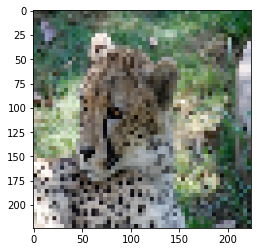

pred
tf.Tensor(19.664722, shape=(), dtype=float32) tf.Tensor(0.54708356, shape=(), dtype=float32)
1.0 0.0
1.0 0.0
<class 'numpy.ndarray'>


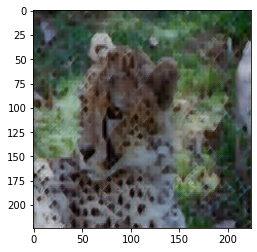

hr


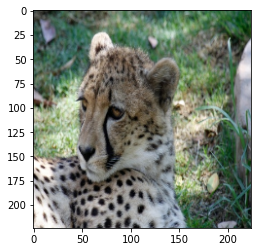

In [ ]:
test_hr = keras.utils.image_dataset_from_directory(
                                        path_test, validation_split=0.2, 
                                        subset="training",
                                        label_mode=None,
                                        seed=1, image_size=(224, 224))

test_lr = keras.utils.image_dataset_from_directory(
                                        path_test, validation_split=0.2, 
                                        subset="training",
                                        label_mode=None,
                                        seed=1, image_size=(56, 56))

y_test=[]
x_test=[]

for images in test_hr.take(1):
  for i in range(len(images)):
    y_test.append(images[i])

for images in test_lr.take(1):
  for i in range(len(images)):
    x_test.append(images[i])

y_test = np.array(y_test)/255
x_test = np.array(x_test)/255
x_test = pre_upsamping(x_test)

pred = RUnet.predict(x_test[0][np.newaxis,...])
print('lr')
print(psnr(y_test[0],x_test[0]), ssim(y_test[0],x_test[0]))
plt.imshow(x_test[0])
print(type(x_test[0]))
plt.show()

print('pred')
print(psnr(y_test[0],pred[0,:,:,:]), ssim(y_test[0],pred[0,:,:,:]))
img = pred[0,:,:,:]
# img = img/np.amax(img)
# img[img<0] = 0
# print(np.amax(img), np.amin(img))
# maxValue = np.amax(img)
# minValue = np.amin(img)
# print(maxValue, minValue)
plt.imshow(img)
# plt.imshow((out * 255).astype(np.uint8))
print(type(pred[0,:,:,:]))
plt.show()

print('hr')
# print(psnr(y_train[k], y_train[k]))
plt.imshow(y_test[0])
# print(type(y_train[k]))
plt.show()

(224, 224, 3)


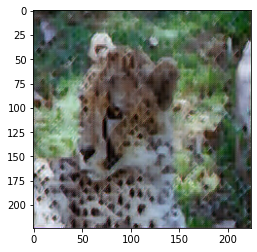

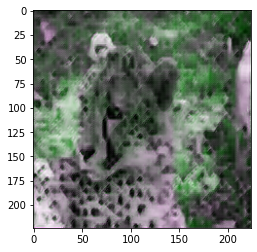

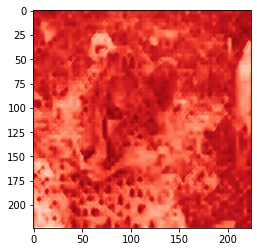

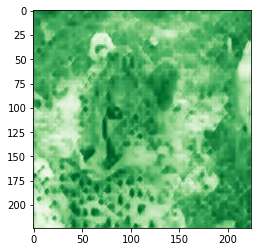

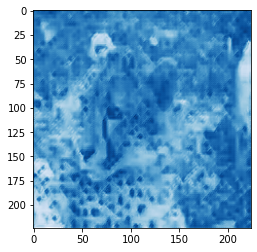

In [ ]:
from google.colab.patches import cv2_imshow

print(img.shape)

plt.imshow(img)
plt.show()

R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
img1 = img

img1[:,:,0] = img[:,:,2]
img1[:,:,1] = img[:,:,1]
img1[:,:,2] = img[:,:,0]
plt.imshow(img1)
plt.show()
plt.imshow(img[:,:,2], cmap=plt.cm.Reds_r)
plt.show()
plt.imshow(img[:,:,1], cmap=plt.cm.Greens_r)
plt.show()
plt.imshow(img[:,:,0], cmap=plt.cm.Blues_r)
plt.show()

# dist2 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
# cv2_imshow(dist2)
# (R,G,B) = cv2.split(dist2)
# red = np.zeros((224, 224, 3))
# red[: , :, 2] = R
# cv2_imshow(red)

# green = np.zeros((224, 224, 3))
# green[: , :, 1] = G
# cv2_imshow(green)

# blue = np.zeros((224, 224, 3))
# blue[: , :, 0] = B
# cv2_imshow(blue)

# cv2_imshow(red+blue)

## Dodatkowe metodu SR niezwiązane z głębokim uczeniem

In [ ]:
size = [224, 224]
plt.figure()

# for images,labels in images_hr.take(1):
#   reference_img = images[0]

reference_img = y_test[0]
upscaling_results = []
test_img = tf.image.resize(reference_img[...], [56, 56])
upscaling_results = [(reference_img, 'original')]
upscaling_results.append((test_img, 'downscaled'))

<Figure size 432x288 with 0 Axes>

### Bicubic interpolation

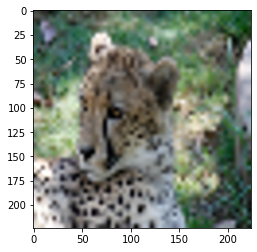

In [ ]:
resized = tf.image.resize(
      test_img,
      size,
      method='bicubic',
      preserve_aspect_ratio=False,
  )
upscaling_results.append((resized, 'bicubic'))
plt.imshow(resized[:,:,:])
plt.show()

### Nearest neighbour interpolation

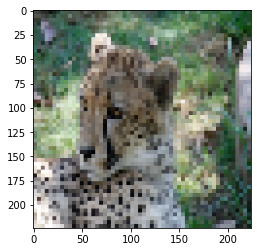

In [ ]:
resized = tf.image.resize(
      test_img,
      size,
      method='nearest',
      preserve_aspect_ratio=False,
  )

upscaling_results.append((resized, 'nearest neighbour'))
plt.imshow(resized[:,:,:])
plt.show()

### Bilinear interpolation

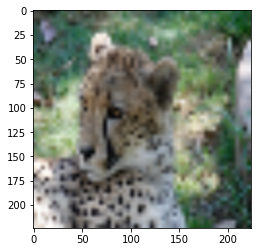

In [ ]:
resized = tf.image.resize(
    test_img,
    size,
    method='bilinear',
    preserve_aspect_ratio=False,
)

upscaling_results.append((resized, 'bilinear'))
plt.imshow(resized[:,:,:])
plt.show()

### Lanczos kernel (radius 5)

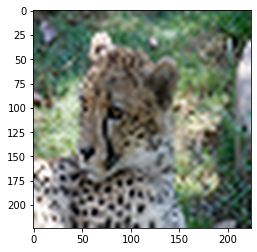

In [ ]:
resized = tf.image.resize(
    test_img,
    size,
    method='lanczos5',
    preserve_aspect_ratio=False,
)

upscaling_results.append((resized, 'Lnanczos 5'))
plt.imshow(resized[:,:,:])
plt.show()

### Gaussian kernel

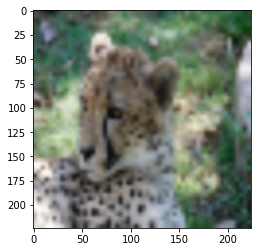

In [ ]:
resized = tf.image.resize(
    test_img,
    size,
    method='gaussian',
    preserve_aspect_ratio=False,
)

upscaling_results.append((resized, 'Gaussian'))

plt.imshow(resized[:,:,:])
plt.show()

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

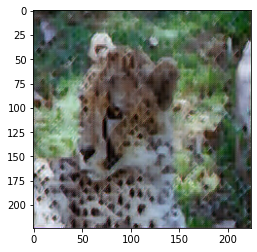

In [ ]:
img = pred[0,:,:,:]
plt.imshow(img)

In [ ]:
upscaling_results.append((img, 'RUNet'))

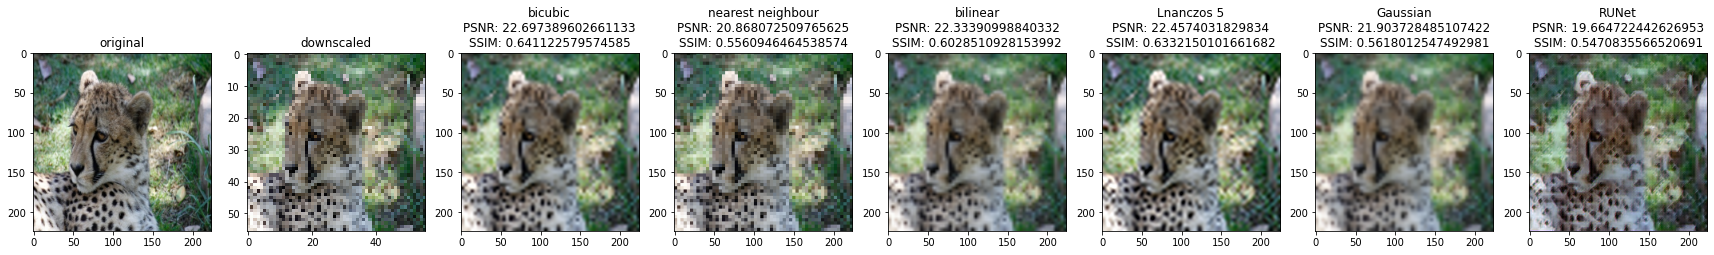

In [ ]:
i = 0
fig, ax = plt.subplots(2, 4, figsize=(30,30))
for img, name in upscaling_results:
  plt.subplot(1, 8, i+1)
  if name == 'downscaled' or name == 'original':
    plt.title(f"{name}")
  else:
    psnr_score = psnr(img, reference_img)
    ssim_score = ssim(img, reference_img)
    plt.title(f"{name}\nPSNR: {psnr_score}\nSSIM: {ssim_score}")
  plt.imshow(img)
  i += 1


TODO:
- argumentacja
- zmiana funkcji straty
- zmiana vgg na resnet (albo coś nowszego)
- zmiana sgd na Adama + loss sche...
- zmiana runet unet

Zmiana Adam na SGD(lr=0,01 i lr=0,1) -> bez znacznych zmian, psnr między 6, a 16  
Zmiana vgg na resnet bez znacznych zmian -> psnr do 17  
Blurowanie podczas trenowania x_train + adam(lr=0,01) -> wyeliminowanie problemu z kolorem  
Na obrazie testowym:  
porównując z innymi metodami psnr dla RUnet niższe od każdej  
pozostalej metody jednak wizualnie od nich lepsze.  
SSIM również niższe względem pozostałych metod.

# OpenCV SR

In [ ]:
import math

def psnr(target, ref):
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))
    print(rmse)
    return 20 * math.log10(255. / rmse)

In [ ]:
# from matplotlib.pyplot import figure

# figure(figsize=(12, 12))
# img = mpimg.imread('/content/dams.jpg')
# imgplot = plt.imshow(img)
# plt.show()

# figure(figsize=(12, 12))
# img = mpimg.imread('/content/upscaled_dams.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [ ]:
# # https://medium.com/towards-data-science/deep-learning-based-super-resolution-with-opencv-4fd736678066

# import cv2
# from cv2 import dnn_superres

# # Create an SR object
# sr = dnn_superres.DnnSuperResImpl_create()

# # Read image
# image = cv2.imread('/content/opos_64.png')

# # Read the desired model
# path = "/content/EDSR_x3.pb"
# sr.readModel(path)

# # Set CUDA backend and target to enable GPU inference
# sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# # Set the desired model and scale to get correct pre- and post-processing
# sr.setModel("edsr", 3)

# # Upscale the image
# result = sr.upsample(image)

# # Save the image
# cv2.imwrite("/content/upscaled.png", result)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img = mpimg.imread('/content/opos_64.png')
# imgplot = plt.imshow(img)
# plt.show()

# img = mpimg.imread('/content/upscaled.png')
# imgplot = plt.imshow(img)
# plt.show()

In [ ]:
# image = cv2.imread('/content/dams.jpg')

# # Upscale the image
# result = sr.upsample(image)

# # Save the image
# cv2.imwrite("/content/upscaled_dams.jpg", result)

In [ ]:
# target = cv2.imread('/content/upscaled.png')
# ref = cv2.imread('/content/opos.jpeg')

# img = mpimg.imread('/content/opos.jpeg')
# imgplot = plt.imshow(img)
# plt.show()

# img = mpimg.imread('/content/upscaled.png')
# imgplot = plt.imshow(img)
# plt.show()

# img = mpimg.imread('/content/opos_64.png')
# imgplot = plt.imshow(img)
# plt.show()

# print(f'PSNR: {psnr(target, ref)}')